In [1]:
import pandas as pd
import numpy as np
import os
import gget
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sys
import itertools
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy

import utils as ut

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
]

print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = lf.drop_duplicates(subset='cellId')
    lf = lf[lf['cellType'].isin(macTypes)]
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    

    cellIds = lf['cellId'].to_list()
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']

    rf = rf[rf.index.isin(cellIds)]
    print(f"{key=} {lf.shape=} {rf.shape}")
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf
    

print('done')


ND...
key='ND' lf.shape=(536, 6) (534, 31053)
HFD8...
key='HFD8' lf.shape=(2909, 6) (2902, 31053)
HFD14...
key='HFD14' lf.shape=(4903, 6) (4893, 31053)
done


In [3]:
for key in keys:
    ldf = labels[key]
    print(ldf.head())

               cellId   cellType sampleInfo         x         y   colors
0  AAAGAACGTCTACAGT.1       Mac1         ND  3.089298 -1.726030  #fdbf6f
1  AAAGAACTCCTCGCAT.1       Mac1         ND  3.614130 -1.571004  #fdbf6f
2  AAAGGGCGTTAGGGTG.1       Mac3         ND  3.086352  6.166065  #fdbf6f
3  AACAAAGAGTATAGGT.1  Monocytes         ND  3.178745  4.929769  #ffffbe
4  AACAAAGCACCGGCTA.1       Mac3         ND  4.344001  5.801922  #fdbf6f
               cellId   cellType sampleInfo         x         y   colors
0  AAACCCACACAAAGCG.1       Mac4       HFD8 -0.985782  2.308999  #fdbf6f
1  AAACGCTTCGGACCAC.1       Mac2       HFD8  4.749476  0.898241  #fdbf6f
2  AAACGCTTCTGCAGCG.1  Monocytes       HFD8  2.145450  3.994834  #ffffbe
3  AAAGAACCAAAGCGTG.1       Mac5       HFD8 -4.052603  0.994102  #fdbf6f
4  AAAGAACCAACACGAG.1       Mac4       HFD8 -1.026867  2.441957  #fdbf6f
               cellId   cellType sampleInfo         x         y   colors
0  AAACCCAAGACTTCAC.1       Mac5      HFD14 -0.5877

In [4]:
# merge all expression
rdf = []
for key in keys:
    rf = rna[key].copy()
    rf.index = rf.index + "_" + key
    rdf.append(rf)

rdf = pd.concat(rdf)
print(f"{rdf.shape=}")
rdf.head()

rdf.shape=(8329, 31053)


Unnamed: 0,XKR4,GM1992,GM37381,RP1,SOX17,GM37323,MRPL15,LYPLA1,GM37988,TCEA1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,VMN2R122,CAAA01147332.1
cellId,,,,,,,,,,,,,,,,,,,,,
AAAGAACGTCTACAGT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365.89828,...,0.0,0.0,0.0,0.0,0.0,0.0,365.89828,365.89828,0.0,0.0
AAAGAACTCCTCGCAT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1103.509159,220.701832,0.0,0.0
AAAGGGCGTTAGGGTG.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,111.994624,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.994624
AACAAAGAGTATAGGT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,99.532199,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.532199,0.0,0.0
AACAAAGCACCGGCTA.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,85.697146,0.0,0.0,0.0


In [13]:
""" Build the reference dataframe """
ref = []
for key in keys:
    lf = labels[key]
    ref.append(lf)

ref = pd.concat(ref, ignore_index=True)
ref = ref.rename(columns={'sampleInfo' : 'key'})
ref['id'] = ref['cellId'] + "_" + ref['key']
print(f"{ref.shape=}")
ref.head()

ref.shape=(8348, 7)


,cellId,cellType,key,x,y,colors,id
0,AAAGAACGTCTACAGT.1,Mac1,ND,3.089298,-1.726030,#fdbf6f,AAAGAACGTCTACAGT.1_ND
1,AAAGAACTCCTCGCAT.1,Mac1,ND,3.614130,-1.571004,#fdbf6f,AAAGAACTCCTCGCAT.1_ND
2,AAAGGGCGTTAGGGTG.1,Mac3,ND,3.086352,6.166065,#fdbf6f,AAAGGGCGTTAGGGTG.1_ND
3,AACAAAGAGTATAGGT.1,Monocytes,ND,3.178745,4.929769,#ffffbe,AACAAAGAGTATAGGT.1_ND
4,AACAAAGCACCGGCTA.1,Mac3,ND,4.344001,5.801922,#fdbf6f,AACAAAGCACCGGCTA.1_ND


In [7]:
pid =  "mmu04140"
genes = ut.parseKEGG(pid)
genes = [x.upper() for x in genes]
print(len(genes))

142


In [8]:
genes = [x for x in genes if x in rdf.columns]
print(len(genes))

139


In [9]:
adf = rdf[genes]
print(adf.shape)

(8329, 139)


In [21]:
adf.index[:10]

Index(['AAAGAACGTCTACAGT.1_ND', 'AAAGAACTCCTCGCAT.1_ND',
       'AAAGGGCGTTAGGGTG.1_ND', 'AACAAAGAGTATAGGT.1_ND',
       'AACAAAGCACCGGCTA.1_ND', 'AACAAAGGTTCACGAT.1_ND',
       'AACAACCGTTGACTAC.1_ND', 'AACAGGGAGCTGAAGC.1_ND',
       'AACCAACGTGTTGAGG.1_ND', 'AACCAACTCCGATTAG.1_ND'],
      dtype='object', name='cellId')

<AxesSubplot: xlabel='None-type', ylabel='gene'>

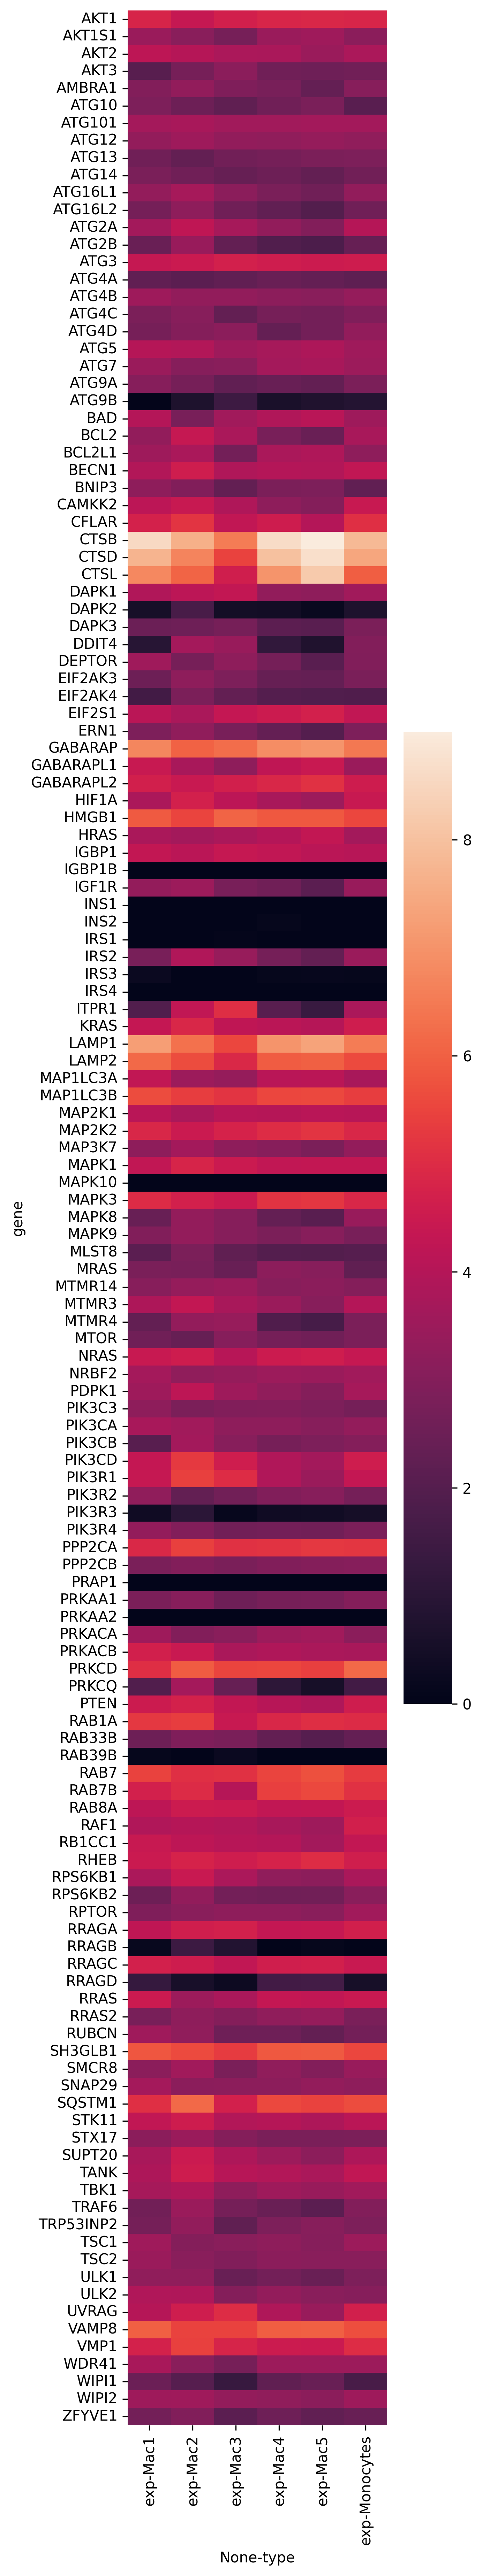

In [44]:
# get 

res = []

for mact in ref['cellType'].unique():
    cids = ref[ref['cellType'] == mact]['id']

    kdf = adf[adf.index.isin(cids)]

    means = pd.DataFrame(kdf.mean(axis=0)).reset_index(drop=False)
    means.columns = ['gene', 'exp']
    means['type'] = mact
    res.append(means)


res = pd.concat(res)
res = pd.pivot_table(res, index='gene',columns='type')
res = res.astype(float)
res = np.log1p(res)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 30
sns.heatmap(data=res)

    


In [12]:
ref.head()


NameError: name 'ref' is not defined

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
break